In [32]:
import numpy as np  
import matplotlib.pyplot as plt
import gendata
import torch
from models.wdgrl_model import *
from tqdm.auto import trange

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
def clustering(
        X, 
        n_cluster: int = 2):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels, kmeans

## Gen data

In [34]:
ns, nt, d = 2000, 100, 16

In [35]:
Xs, Ys, Xt, Yt, info = gendata.gen_domain_adaptation_data(
    n_source=ns,
    n_target=nt,
    n_features=d,
    n_clusters=2,
    domain_shift_type="covariate",
    shift_magnitude=2.0,  # Moderate shift
    noise_ratio=0.00,
    random_state=1812140441,
    base_center = (-2,2),
    cluster_std_source = 1,
    cluster_std_target = 2,
)

Fixed andom seed = 1812140441


## TSNE 2d plot

Running t-SNE dimensionality reduction...


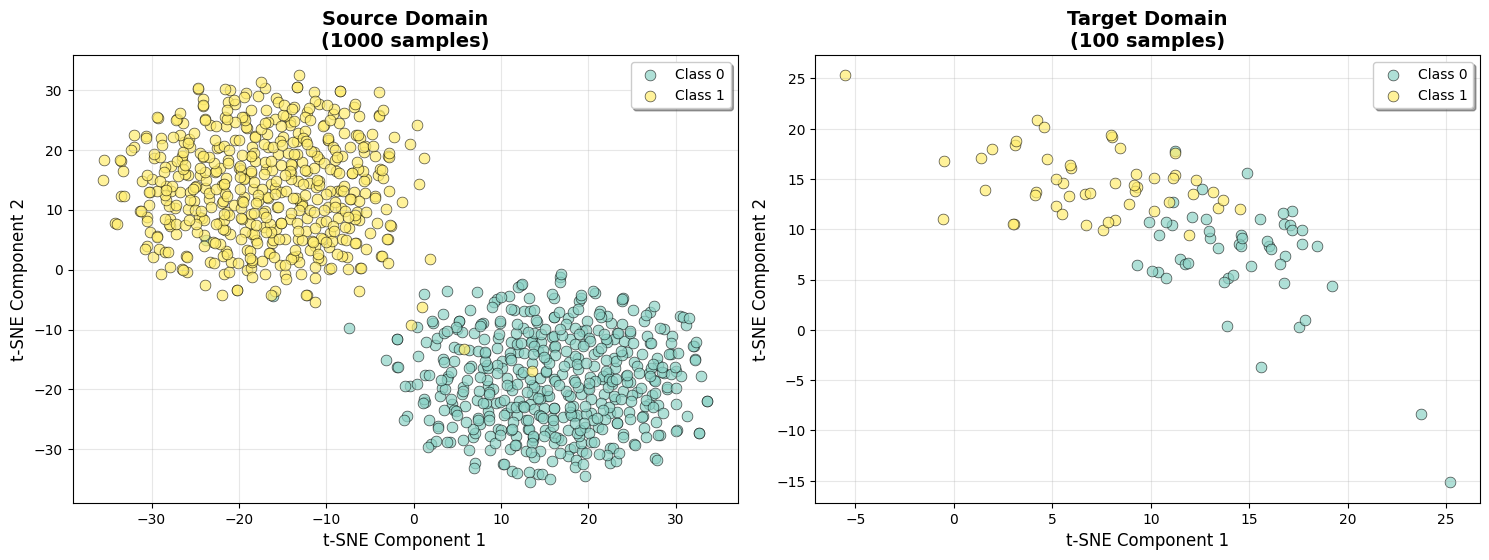

In [36]:
gendata.visualby_tsne(Xs,Xt,Ys,Yt)

## Original clustering

In [37]:

cluster_labels, model1 = clustering(Xt)

ari = adjusted_rand_score(Yt, cluster_labels)
print(f'Adjusted Rand Index (ARI) only on target domain: {ari:.4f}')

Adjusted Rand Index (ARI) only on target domain: 0.6363


___

In [38]:
xs = torch.from_numpy(Xs).float()
ys = torch.from_numpy(Ys).long()
xt = torch.from_numpy(Xt).float()
yt = torch.from_numpy(Yt).long()

In [39]:
from torch.utils.data import DataLoader, TensorDataset

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)



## WDGRL

In [40]:
encoder_hidden_dims = [10]
critic_hidden_dims = [10,10]
model = WDGRL(
    input_dim=d, 
    encoder_hidden_dims=encoder_hidden_dims,
    critic_hidden_dims=critic_hidden_dims,
    _lr_encoder = 1e-3,
    _lr_critic = 1e-3,
    seed=42)
model.encoder = model.encoder.float()
model.critic = model.critic.float()

losses, source_critic_scores, target_critic_scores = model.train(
    source_dataset, 
    target_dataset,
    num_epochs=200,
    gamma=1,
    dc_iter= 10,
    batch_size=32)

Epoch: 100%|██████████| 200/200 [00:06<00:00, 31.31it/s]


In [41]:
xs_hat = model.extract_feature(xs.cuda())
xt_hat = model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()
print(xs_hat.shape)
print(xt_hat.shape)

(2000, 10)
(100, 10)


In [42]:
x_comb = np.vstack((xs_hat, xt_hat))
comb_cluster_labels, model2 = clustering(x_comb)
ari = adjusted_rand_score(Yt, comb_cluster_labels[ns:])
print(f'Adjusted Rand Index (ARI) of target on transported domain: {ari:.4f}')

Adjusted Rand Index (ARI) of target on transported domain: 0.0480


Running t-SNE dimensionality reduction...


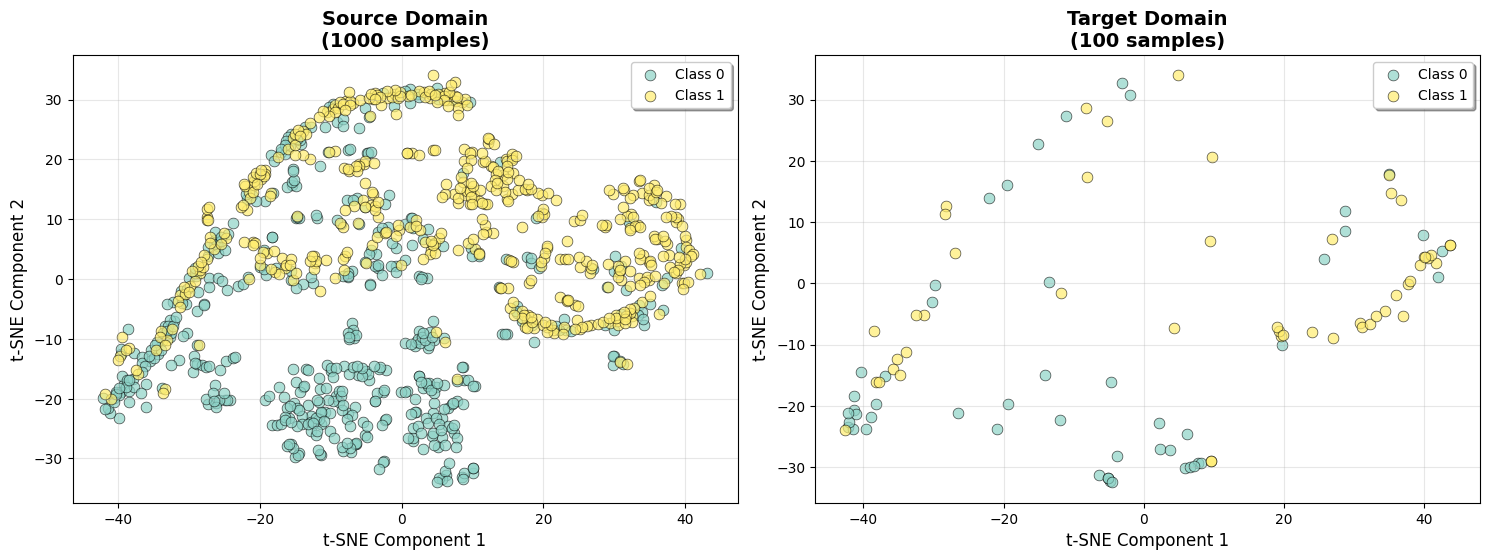

In [43]:
gendata.visualby_tsne(xs_hat, xt_hat, Ys, Yt)

## Fine-tune hyperparams

In [44]:
n_source_small = 800
n_target_small = 80

# Randomly pick indices without replacement
src_indices = torch.randperm(len(xs))[:n_source_small]
tgt_indices = torch.randperm(len(xt))[:n_target_small]

# Create smaller tensors
xs_small = xs[src_indices]
xt_small = xt[tgt_indices]

# Subset labels (Ys, Yt are numpy arrays)
Ys_small = Ys[src_indices.cpu().numpy()]
Yt_small = Yt[tgt_indices.cpu().numpy()]

# Create smaller datasets
source_dataset_small = TensorDataset(xs_small)
target_dataset_small = TensorDataset(xt_small)

In [45]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [46]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

def objective(trial):
    # Hyperparameter search space
    # encoder_hidden_dims = trial.suggest_categorical("encoder_hidden_dims", [[32], [10,10], [32,16]])
    # critic_hidden_dims  = trial.suggest_categorical("critic_hidden_dims", [[10, 10], [32,16], [32]])
    
    n_encoder_layers = trial.suggest_int("n_encoder_layers", 1, 3)
    encoder_hidden_dims = []
    for i in range(n_encoder_layers):
        # Suggest the number of nodes for each encoder layer
        dim = trial.suggest_int(f"encoder_dim_l{i}", d//2, d*3, log=True)
        encoder_hidden_dims.append(dim)
    # This is the line you need to add for the encoder
    trial.set_user_attr("encoder_hidden_dims", encoder_hidden_dims)
    

    # --- Critic Architecture Tuning ---
    # Suggest the number of hidden layers for the critic
    n_critic_layers = trial.suggest_int("n_critic_layers", 1, 5)
    critic_hidden_dims = []
    for i in range(n_critic_layers):
        # Suggest the number of nodes for each critic layer
        dim = trial.suggest_int(f"critic_dim_l{i}", d//2, d*3, log=True)
        critic_hidden_dims.append(dim)
    # This is the line you need to add for the critic
    trial.set_user_attr("critic_hidden_dims", critic_hidden_dims)


    lr_encoder = trial.suggest_float("_lr_encoder", 1e-4, 1e-2, log=True)
    lr_critic  = trial.suggest_float("_lr_critic", 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.005, 10.0)
    dc_iter = trial.suggest_int("dc_iter", 5, 20)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Build WDGRL tune_model
    tune_model = WDGRL(
        input_dim=d,
        encoder_hidden_dims=encoder_hidden_dims,
        critic_hidden_dims=critic_hidden_dims,
        _lr_encoder=lr_encoder,
        _lr_critic=lr_critic,
        seed=42
    )
    tune_model.encoder = tune_model.encoder.float()
    tune_model.critic = tune_model.critic.float()

    # Train (shorter epochs for tuning)
    tune_model.train(
        source_dataset_small, 
        target_dataset_small,
        num_epochs=50,
        gamma=gamma,
        dc_iter=dc_iter,
        batch_size=batch_size
    )

    xs_small_hat = tune_model.extract_feature(xs_small.cuda())
    xt_small_hat = tune_model.extract_feature(xt_small.cuda())
    xs_small_hat = xs_small_hat.cpu().numpy()
    xt_small_hat = xt_small_hat.cpu().numpy()
    
    # Combine and cluster
    x_small_comb = np.vstack((xs_small_hat, xt_small_hat))
    comb_sm_cluster_labels, _ = clustering(x_small_comb)

    # Compute ARI on transported target domain
    ari = adjusted_rand_score(Yt_small, comb_sm_cluster_labels[len(xs_small_hat):])
    return ari  # Optuna will maximize this


In [47]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best params:", study.best_params)
print("Best ARI:", study.best_value)

[I 2025-08-09 17:04:38,742] A new study created in memory with name: no-name-447947ea-418b-4d2c-9b16-9633cf73b134
Epoch: 100%|██████████| 50/50 [00:05<00:00,  8.78it/s]
[I 2025-08-09 17:04:44,460] Trial 0 finished with value: -0.002526875974099521 and parameters: {'n_encoder_layers': 3, 'encoder_dim_l0': 9, 'encoder_dim_l1': 16, 'encoder_dim_l2': 8, 'n_critic_layers': 5, 'critic_dim_l0': 14, 'critic_dim_l1': 8, 'critic_dim_l2': 30, 'critic_dim_l3': 16, 'critic_dim_l4': 37, '_lr_encoder': 0.0024214298337168856, '_lr_critic': 0.0037541549435191855, 'gamma': 6.415316110755002, 'dc_iter': 20, 'batch_size': 64}. Best is trial 0 with value: -0.002526875974099521.
Epoch: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s]
[I 2025-08-09 17:04:46,222] Trial 1 finished with value: -0.0006831036151945173 and parameters: {'n_encoder_layers': 2, 'encoder_dim_l0': 29, 'encoder_dim_l1': 16, 'n_critic_layers': 1, 'critic_dim_l0': 17, '_lr_encoder': 0.0003170309697628615, '_lr_critic': 0.000560334477904092

Best params: {'n_encoder_layers': 1, 'encoder_dim_l0': 31, 'n_critic_layers': 2, 'critic_dim_l0': 12, 'critic_dim_l1': 15, '_lr_encoder': 0.00012696935420372464, '_lr_critic': 0.0021948804230028174, 'gamma': 3.0426816615793983, 'dc_iter': 16, 'batch_size': 32}
Best ARI: 0.48368308310016017


In [48]:
print(study.best_params)

{'n_encoder_layers': 1, 'encoder_dim_l0': 31, 'n_critic_layers': 2, 'critic_dim_l0': 12, 'critic_dim_l1': 15, '_lr_encoder': 0.00012696935420372464, '_lr_critic': 0.0021948804230028174, 'gamma': 3.0426816615793983, 'dc_iter': 16, 'batch_size': 32}


In [49]:
# Assuming 'study' is your Optuna study object after optimization
best_trial = study.best_trial

print("Best Trial:")
print(f"  Value: {best_trial.value}")

print("\n  Directly Suggested Parameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

print("\n  Dynamically Generated Architecture (User Attributes):")
for key, value in best_trial.user_attrs.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.48368308310016017

  Directly Suggested Parameters:
    n_encoder_layers: 1
    encoder_dim_l0: 31
    n_critic_layers: 2
    critic_dim_l0: 12
    critic_dim_l1: 15
    _lr_encoder: 0.00012696935420372464
    _lr_critic: 0.0021948804230028174
    gamma: 3.0426816615793983
    dc_iter: 16
    batch_size: 32

  Dynamically Generated Architecture (User Attributes):
    encoder_hidden_dims: [31]
    critic_hidden_dims: [12, 15]


In [50]:
best_trial.user_attrs["critic_hidden_dims"]

[12, 15]

In [51]:
best_params = study.best_params

final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=best_trial.user_attrs["encoder_hidden_dims"],
    critic_hidden_dims=best_trial.user_attrs["critic_hidden_dims"],
    _lr_encoder=best_params["_lr_encoder"],
    _lr_critic=best_params["_lr_critic"],
    seed=42
)
final_model.encoder = final_model.encoder.float()
final_model.critic = final_model.critic.float()

# Train longer for final fit
final_model.train(
    source_dataset_small,
    target_dataset_small,
    num_epochs=200,  # more epochs for final training
    gamma=best_params["gamma"],
    dc_iter=best_params["dc_iter"],
    batch_size=best_params["batch_size"]
)

Epoch: 100%|██████████| 200/200 [00:12<00:00, 16.06it/s]


([], [], [])

In [52]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

Running t-SNE dimensionality reduction...


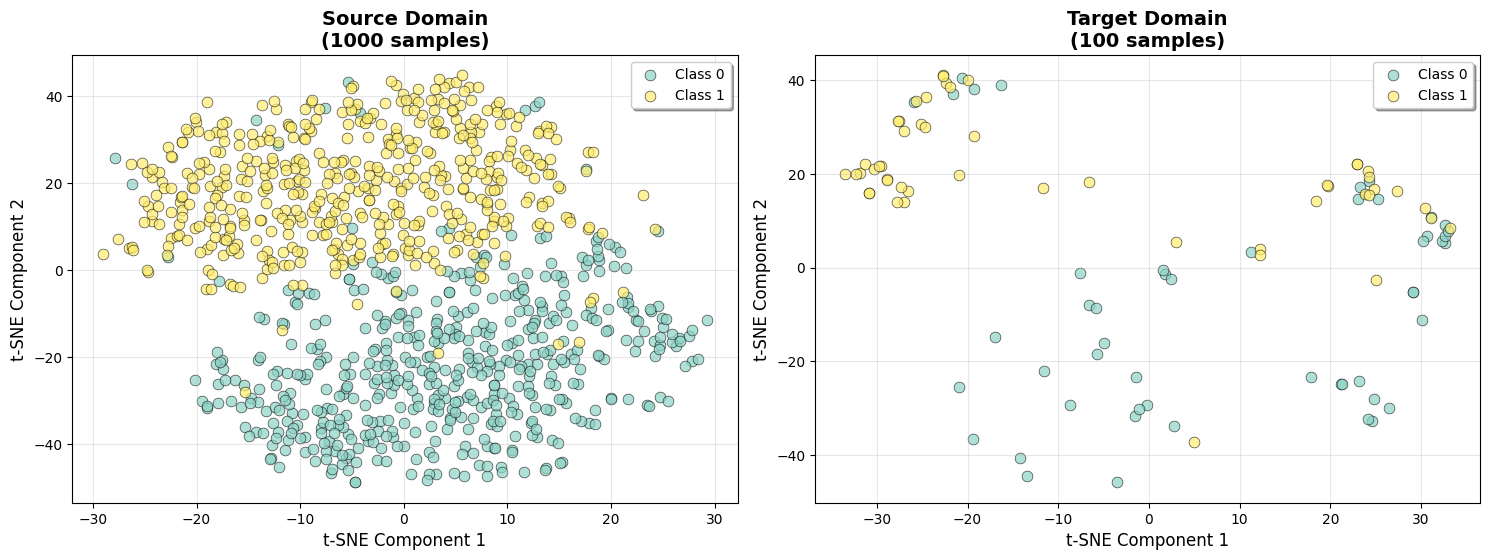

In [53]:
gendata.visualby_tsne(xs_hat, xt_hat, Ys, Yt)

In [54]:
x_comb = np.vstack((xs_hat, xt_hat))
comb_cluster_labels, model2 = clustering(x_comb)
ari = adjusted_rand_score(Yt, comb_cluster_labels[ns:])
print(f'Adjusted Rand Index (ARI) of target on transported domain: {ari:.4f}')

Adjusted Rand Index (ARI) of target on transported domain: 0.6045
